# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

### rolling and slicing wg for `ds_tns` and `ds_vel`, and saving to cloud

### Begin nb

In [3]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [10]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.98210095d76945b4a63f94319049b059 Dashboard: /services/dask-gateway/clusters/prod.98210095d76945b4a63f94319049b059/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


In [142]:
from dask_gateway import Gateway
g = Gateway()
g.list_clusters()[0].name

'prod.b25aa347b02246d2a5fb832642991c54'

In [102]:
client.close()
cluster.close()

In [5]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [6]:
xr.set_options(display_style='text')

In [7]:
#coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) #didn't upload wg region
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr'))
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel_wg.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta_wg.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_wg.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/drhodts_wg.zarr'))
#ds_tmp_slt_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_slt_wg.zarr')) #from sigma-budget-zspace-sose.ipynb

In [8]:
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (XC: 570, XG: 571, YC: 95, YG: 96, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.1 295.2 295.4 ... 29.75 29.92
  * YC                        (YC) float32 -77.87 -77.71 ... -62.37 -62.21
  * Z                         (Z) float32 -5.0 -15.5 ... -5.325e+03 -5.575e+03
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 295.0 295.2 295.3 ... 29.83 30.0
  * YG                        (YG) float32 -77.96 -77.79 ... -62.29 -62.12
  * Zl                        (Zl) float32 0.0 -10.0 ... -5.2e+03 -5.45e+03
Data variables:
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH           (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhods_wg                 (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhodt_wg                 (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 571), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 96, 570), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [9]:
pref = 2000

In [11]:
mask = ds.surface_flux_conv_SLT.where(ds.surface_flux_conv_SLT!=0)

In [9]:
mask

<xarray.DataArray 'surface_flux_conv_SLT' (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<where, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

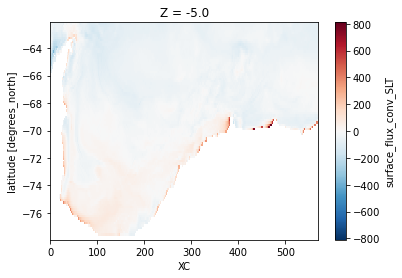

In [11]:
mask.mean(dim='time')[0].drop('XC').plot()

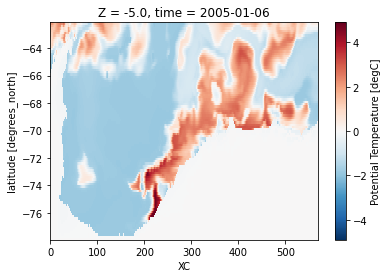

In [12]:
ds_tns.THETA[0,0].where(mask[0,0]).drop('XC').plot()

### Checking if `rhs` and `lhs` seem to match

In [12]:
ds_sig_salt.data_vars

Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [13]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [14]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<add, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

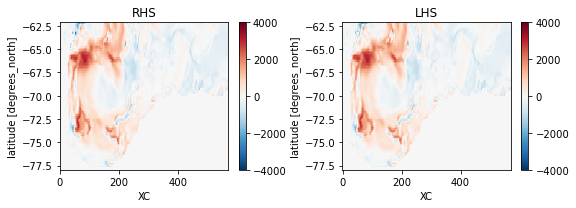

In [15]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].drop('XC').plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].drop('XC').plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [17]:
import dask.array as dsa

In [12]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT, ds_tns.THETA, pref,
                            output_dtypes=[ds_tns.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True)#.load()

In [15]:
sigma2

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<transpose, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

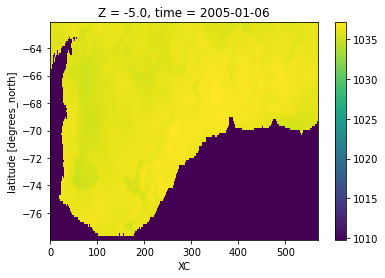

In [16]:
sigma2[0,0].drop('XC').plot()

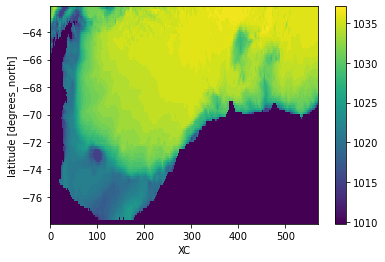

In [18]:
sigma2.mean(dim=['time', 'Z']).drop('XC').plot()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

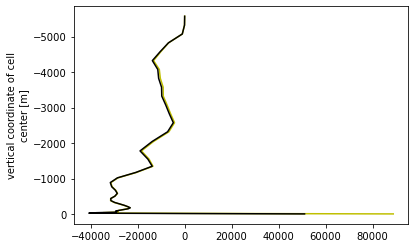

In [17]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['YC', 'XC'])/ total_time).plot(y='Z', yincrease=False, color='y')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k')

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

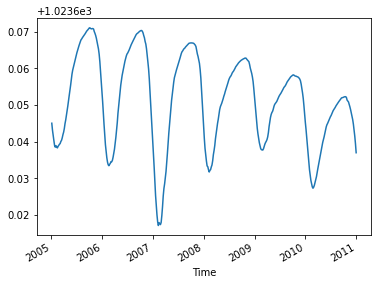

In [22]:
#looks strange but it's similar to ECCO considering the shorter time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.mean(dim=['XC', 'YC', 'Z']).plot()

In [28]:
sigma2.min().values

array(1009.78870743)

In [29]:
sigma2.max().values

array(1037.55056821)

In [30]:
sigma2.where(mask).min().values

array(1009.78870743)

In [13]:
# define bins
delta_sigma = 0.01
sigma_bins = np.arange(1035.55, 1037.55, delta_sigma)

In [14]:
sigma_bins.size

200

In [15]:
ds = ds.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})
coords = coords.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})

In [18]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['XC', 'YC', 'Z']).load()

In [21]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[1.13423144e+11, 1.31609551e+11, 1.57247256e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.32335867e+11, 1.35934326e+11, 1.52830657e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.55675558e+10, 7.18447876e+10, 1.00385727e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.46686310e+09, 4.68402163e+09, 1.48489843e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.07137587e+09, 1.60360922e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.79996928e+09, 4.59207616e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

(1036.9, 1037.3)

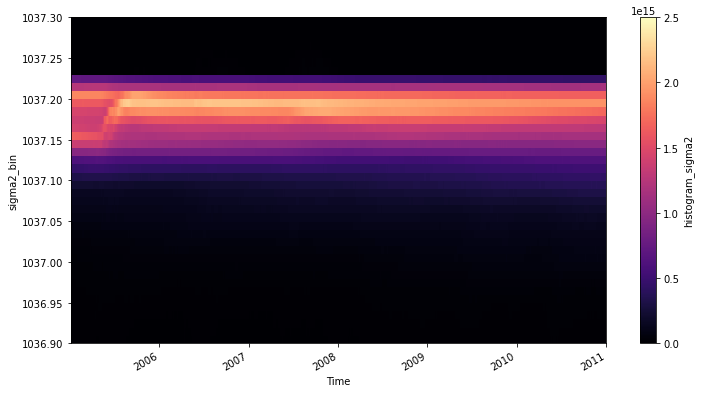

In [22]:
#most volumous water has densities up to 1037.20kg/m^3
#how to check the single-value density for most volumous?
sigma_dist.plot(x='time', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3)

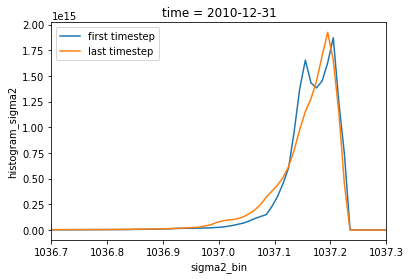

In [29]:
#waters with density up to 1037.13 got denser?
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

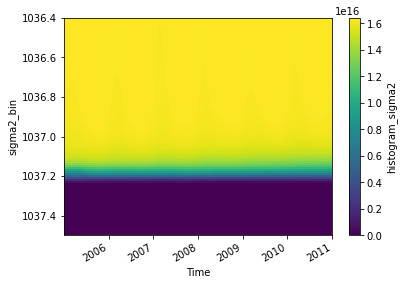

In [19]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.5, 1036.4)

In [24]:
V

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64139676e+16, 1.64140992e+16, 1.64142127e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64159155e+16, 1.64160514e+16, 1.64161838e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64163349e+16, 1.64164068e+16, 1.64164724e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173384e+16, 1.64173431e+16, 1.64173446e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173369e+16, 1.64173385e+16, 1.64173416e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173051e+16, 1.64173097e+16, 1.64173145e+16]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

(1037.5, 1036.5)

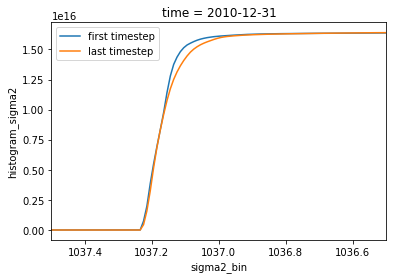

In [32]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1036.5)

In [20]:
delta_V = V.diff(dim='time')

In [26]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 437, sigma2_bin: 199)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.94787812e+12,  1.95220289e+12,  1.97111561e+12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.19444862e+11,  3.55355323e+11,  2.88587012e+11],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.05210419e+09,  2.12652559e+10,  3.74589320e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.12162227e+09, -5.92249907e+09, -7.55408371e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.48489843e+09, -4.56531085e+09, -2.96079808e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.18640164e+10, -2.88755494e+10, -2.71469560e+10]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

In [21]:
dt = ds.time.diff(dim='time').astype(np.float64) / 1e9

In [28]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

## $\frac{\partial \mathcal{V}}{\partial t}$

In [36]:
delta_V.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [37]:
dt.time.dtype

dtype('<M8[ns]')

In [38]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [22]:
dVdt = delta_V / dt

In [30]:
dVdt

<xarray.DataArray (time: 437, sigma2_bin: 199)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.50897712e+06,  4.51898817e+06,  4.56276762e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.70937180e+05,  8.22581767e+05,  6.68025491e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16946856e+04,  4.92251293e+04,  8.67104907e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.11148664e+04, -1.37094886e+04, -1.74863049e+04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.43726489e+03, -1.05678492e+04, -6.85369926e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.37592972e+04, -6.68415496e+04, -6.28401760e+04]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

(1035.5, 1037.3)

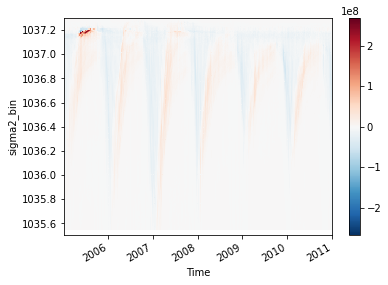

In [31]:
dVdt.plot(x='time')
plt.ylim(1035.5, 1037.3)

## $\Omega_{total}$

In [32]:
omega_total_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_TH_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (- delta_sigma)
omega_total_th.load()

omega_total_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_SLT_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (-delta_sigma)
omega_total_slt.load()

omega_total = omega_total_th + omega_total_slt
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[-7172956.10454818, -7655417.42540483, -8085171.1515464 , ...,
               0.        ,        0.        ,        0.        ],
       [ 2504602.97945385,  1667390.14222579,  3906577.14988093, ...,
               0.        ,        0.        ,        0.        ],
       [  296299.10556494,   403174.45544963,   581782.68925796, ...,
               0.        ,        0.        ,        0.        ],
       ...,
       [  -39980.49972141,  -107475.9904712 ,   -34312.24048652, ...,
               0.        ,        0.        ,        0.        ],
       [   69205.99491557,    81527.30795351,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [  131151.84057438,  -193441.38385013,        0.        , ...,
               0.        ,        0.        ,        0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

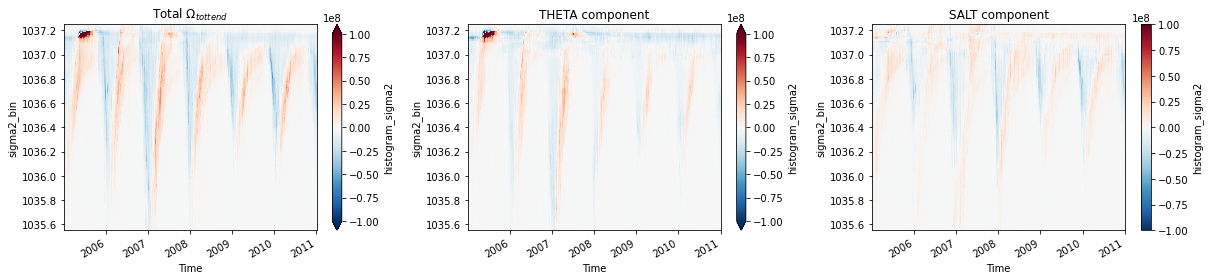

In [63]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25)
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

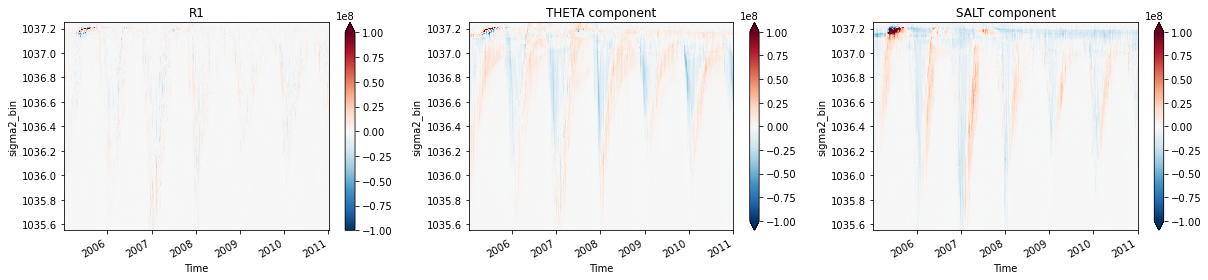

In [64]:
R1 = dVdt - omega_total
R1_th = dVdt - omega_total_th
R1_slt = dVdt - omega_total_slt

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25)
ax2.set_title('SALT component')

plt.tight_layout();

In [65]:
plot_terms = np.array([[dVdt, omega_total, R1], [dVdt, omega_total_th, R1_th], [dVdt, omega_total_slt, R1_slt]])
plot_term_titles = np.array([[r'$\frac{\partial \mathcal{V}}{\partial t}$', 
                              '$\Omega$ (total_tendency)', 
                              r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Theta Component',
                              r'R1 Theta Component'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Salt Component',
                              r'R1 Salt Component']])

<ipython-input-65-8dc670f46d27>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  plot_terms = np.array([[dVdt, omega_total, R1], [dVdt, omega_total_th, R1_th], [dVdt, omega_total_slt, R1_slt]])


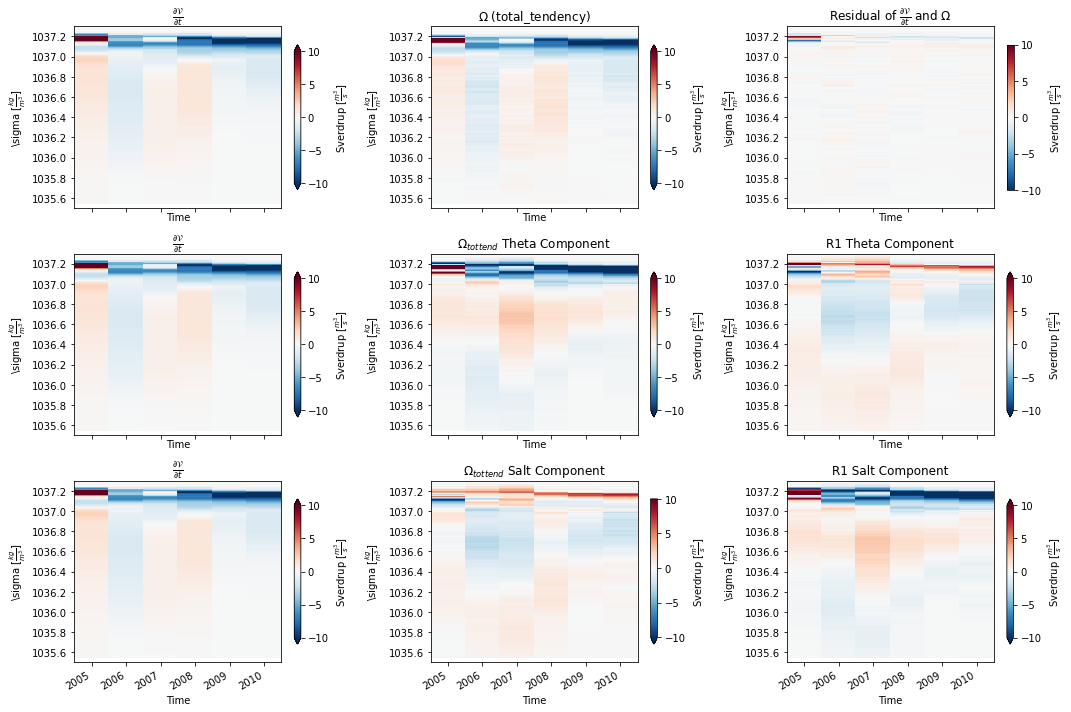

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

for i in range(0,3):
    for j in range(0,3): 
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        (term/1e6).resample(time='AS').mean(dim='time').plot(x='time', vmax=10, ax=axes[i,j],
                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
        axes[i,j].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
        axes[i,j].set_xlabel('Time')
        axes[i,j].set_title(title)
        axes[i,j].set_ylim(1035.5, 1037.3)
plt.tight_layout();

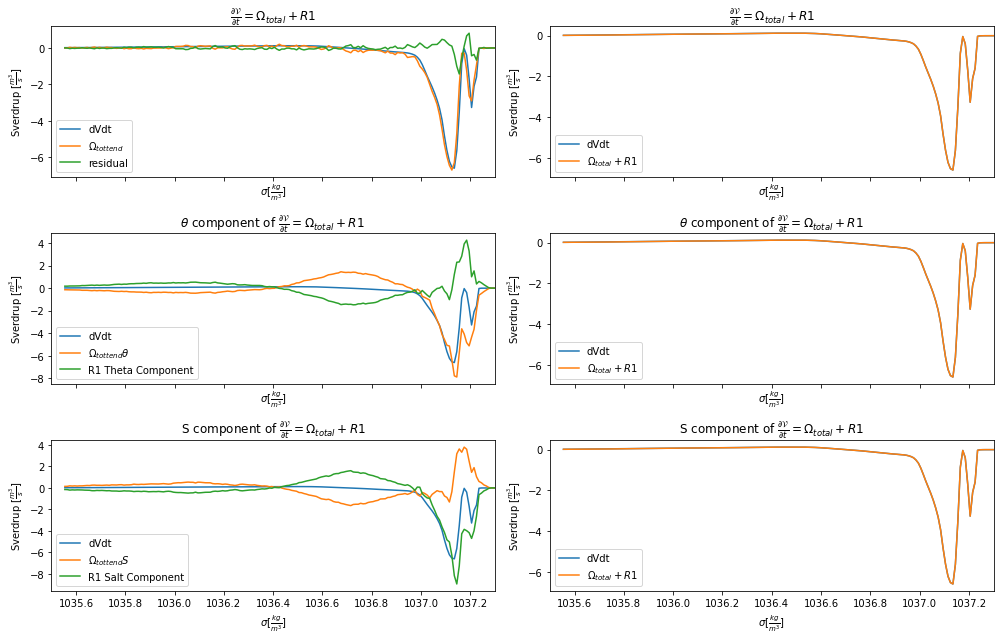

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
axes[1,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[1,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,1].set_xlim(1035.5, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [68]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=variable.fillna(0.), dim=['XC', 'YC', 'Z'])
    return hist / (-delta_sigma)

In [69]:
all_tendencies_th = list(ds_sig_theta)
all_tendencies_slt = list(ds_sig_salt)

In [70]:
all_dsets_th = xr.merge([histogram_func(ds_sig_theta[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_th])
all_dsets_slt = xr.merge([histogram_func(ds_sig_salt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_slt])

In [71]:
all_dsets = xr.merge([all_dsets_th, all_dsets_slt])

In [72]:
all_dsets_slt

<xarray.Dataset>
Dimensions:                         (sigma2_bin: 199, time: 438)
Coordinates:
  * time                            (time) datetime64[ns] 2005-01-06 ... 2010...
  * sigma2_bin                      (sigma2_bin) float64 1.036e+03 ... 1.038e+03
Data variables:
    OMEGA_conv_horiz_adv_flux_SLT   (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SLT  (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_lin_fs_correction_SLT     (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_surface_flux_conv_SLT     (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [73]:
omega_trans_rate_th = - (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                         all_dsets_th.OMEGA_conv_vert_diff_flux_TH +
                         all_dsets_th.OMEGA_lin_fs_correction_TH +
                         all_dsets_th.OMEGA_sw_flux_conv_TH + 
                         all_dsets_th.OMEGA_surface_flux_conv_TH)
omega_trans_rate_th.load()

omega_trans_rate_slt = - (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                          all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT +
                          all_dsets_slt.OMEGA_lin_fs_correction_SLT +
                          all_dsets_slt.OMEGA_surface_flux_conv_SLT)
omega_trans_rate_slt.load()

omega_trans_rate = omega_trans_rate_th + omega_trans_rate_slt
omega_trans_rate.load()

<xarray.DataArray (time: 438, sigma2_bin: 199)>
array([[ 7.23949124e+07,  8.53214624e+07,  1.02416465e+08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.83153488e+06, -7.78911417e+06, -7.72048191e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.44763527e+06, -1.58867179e+06, -3.02207758e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.86186399e+04, -1.96508974e+05, -2.36625525e+05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.35304141e+04,  6.91290274e+03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.97406870e+04, -9.15638046e+04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

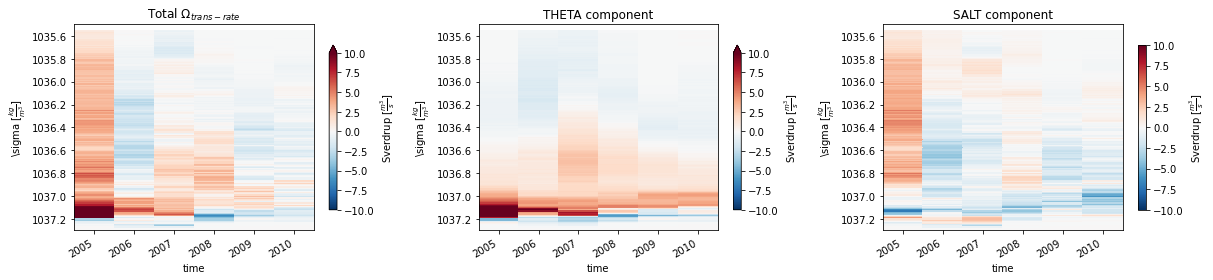

In [74]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_trans_rate_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_trans_rate_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [75]:
psi_adv_th = -(all_dsets_th.OMEGA_conv_horiz_adv_flux_TH + all_dsets_th.OMEGA_conv_vert_adv_flux_TH)
psi_adv_th.load()
psi_adv_slt = -(all_dsets_slt.OMEGA_conv_horiz_adv_flux_SLT + all_dsets_slt.OMEGA_conv_vert_adv_flux_SLT)
psi_adv_slt.load()
psi_adv = psi_adv_th + psi_adv_slt
psi_adv.load()

<xarray.DataArray (time: 438, sigma2_bin: 199)>
array([[-7.95678907e+07, -9.29768752e+07, -1.10501630e+08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.33612709e+06,  9.45650687e+06,  1.16270348e+07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.74393164e+06,  1.99185313e+06,  3.60386733e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.86384476e+04,  8.90328485e+04,  2.02313290e+05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.32737207e+05,  7.46144463e+04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.50893155e+05, -1.01877477e+05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

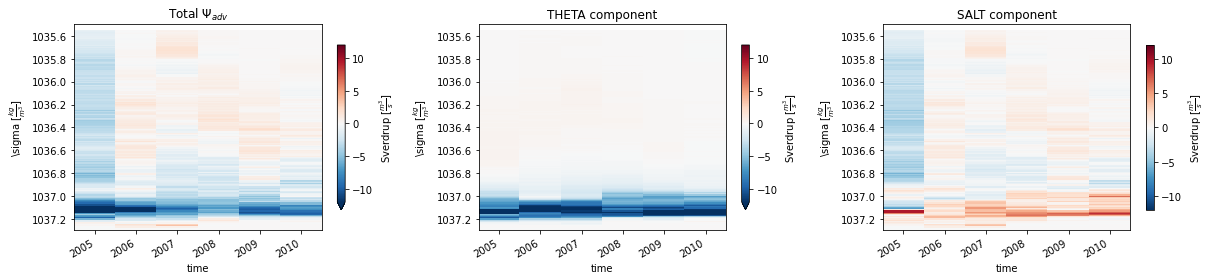

In [76]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(psi_adv.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=12,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Psi_{adv}$')

(psi_adv_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=12,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(psi_adv_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=12,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## $\Psi_{vel}$

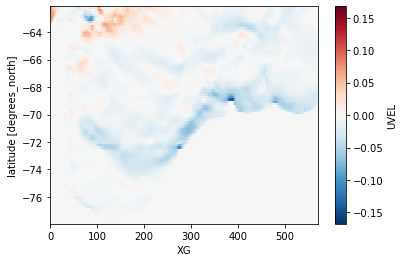

In [89]:
ds.UVEL.mean(dim=['time', 'Z']).drop('XG').plot()

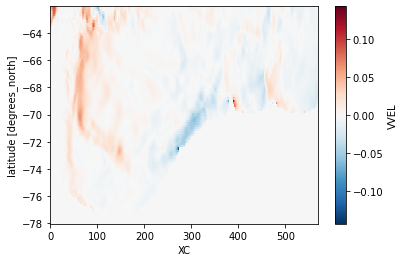

In [91]:
ds.VVEL.mean(dim=['time', 'Z']).drop('XC').plot()

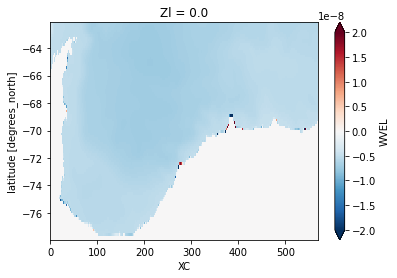

In [110]:
ds.WVEL.mean('time')[0].drop('XC').plot(vmax=0.2e-7)

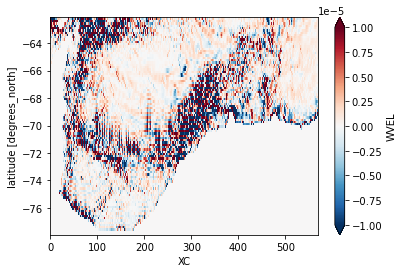

In [102]:
ds.WVEL.mean(dim=['time', 'Zl']).drop('XC').plot(vmax=1e-5)

In [93]:
ds.UVEL

<xarray.DataArray 'UVEL' (time: 438, Z: 42, YC: 95, XG: 571)>
dask.array<xarray-UVEL, shape=(438, 42, 95, 571), dtype=float32, chunksize=(1, 42, 95, 571), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * XG       (XG) float32 295.0 295.2 295.3 295.5 ... 29.5 29.67 29.83 30.0
Attributes:
    long_name:      Zonal Component of Velocity (m/s)
    mate:           VVEL
    standard_name:  UVEL
    units:          m/s

In [23]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(XG=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(XG=0)

v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(YG=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVEL.isel(Zl=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [78]:
u_transport_mean_value = (u_transport_right.sum(dim=['YC', 'Z']) -
                          u_transport_left.sum(dim=['YC', 'Z'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-45.03806, dtype=float32)

In [79]:
v_transport_mean_value = (v_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(46.015747, dtype=float32)
Coordinates:
    YG       float32 -62.12

In [80]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.02791281, dtype=float32)
Coordinates:
    Zl       float32 0.0

In [81]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.94977504, dtype=float32)
Coordinates:
    YG       float32 -62.12
    Zl       float32 0.0

In [24]:
# hack sigma to be on same grid pt as velocity components
sigma_at_u_right = sigma2.isel(XC=-1)
sigma_at_u_left = sigma2.isel(XC=0)
sigma_at_v = sigma2.isel(YC=-1)
sigma_at_w = sigma2.isel(Z=0)

In [28]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right, dim=['Z', 'YC']) 
u_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left, dim=['Z', 'YC'])
v_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport, dim=['Z', 'XC'])
w_binned = histogram(sigma_at_w.rename('sigma2'), bins=[sigma_bins],
                     weights=w_transport, dim=['XC', 'YC'])

In [98]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right.isel(time=slice(0,4)) 
             + v_binned.isel(time=slice(0,4))).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 4, sigma2_bin: 199)>
array([[       -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,  -2764420.57092667,  -6044082.81470299,
         -9356284.58466244, -11545918.17525434, -13062728.72877455,
        -14611683.31132627, -15782358.93042111, -20768671.50963712,
        -23680184.37989044, -22352473.66626   , -21257539.71188664,
        -20275373.15208888, -19534167.93578506, -19058852.74101973,
        -18957513.24260792, -18682406.08579049, -18434166.66316208,
        -17946302.54245076, -17819159.70614704, -17720654.39267191,
        -17438542.67320237, -17413691.60646471, -17428342.84834704,
        -17230316.53102908, -17264120.9074634 , -17150367.15921816,
        -17340341.29103884, -17408991.18216738, -17466399.02919802,
...
        -22557045.11774056, -22534229.50924675, -22577305.88033478,
        -22607043.29291146, -22641659.23636238, -22641411.89745037,
        -22652282.53813545, -22625353.3933448 , -22593647.92657845,
        -22582512.8830661 , -22580048.40960877, -22608771.06198685,
        -22600761.61170284, -22604819.70400707, -22615755.02494042,
        -22616460.49709694, -22614897.45032875, -22577751.21394341,
        -22568602.82740776, -22569106.02572624, -22588699.78076164,
        -22579083.75502007, -22582079.31117241, -22580099.66615288,
        -22601930.24843876, -22607419.32783024, -22613298.04072087,
        -22613298.04072087, -22615330.30268376, -22620640.41157047,
        -22622410.88410465, -22622410.88410465, -22622310.6287946 ,
        -22623878.25879948, -22603430.30219547, -22605840.52802555,
        -22609690.07783024, -22609690.07783024, -22609690.07783024,
        -22609690.07783024, -22609690.07783024, -22593991.9381818 ,
        -22593991.9381818 , -22593991.9381818 , -22593991.9381818 ,
        -22593991.9381818 , -22593991.9381818 , -22593991.9381818 ,
        -22593991.9381818 , -22593991.9381818 , -22593991.9381818 ,
        -22593991.9381818 , -22593991.9381818 , -22593991.9381818 ,
        -22593991.9381818 , -22593991.9381818 , -22593991.9381818 ,
        -22593991.9381818 ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2005-01-21
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

In [100]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (- u_binned_left.isel(time=slice(0,4)) + 
             v_binned.isel(time=slice(0,4))).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 4, sigma2_bin: 199)>
array([[       -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,        -0.        ,        -0.        ,
               -0.        ,  -2764420.57092667,  -5790244.77310753,
         -8921113.5624094 , -11114150.51439238, -12817891.76955748,
        -15189945.87804914, -16783984.80085492, -23434184.55826306,
        -26757077.83958817, -26177653.01346993, -25789864.16224599,
        -25662064.37451243, -25598751.05774474, -25159667.67531157,
        -25593701.04872593, -25316045.15924248, -25312435.60822663,
        -24969648.0873383 , -25278866.2459763 , -25104263.9714416 ,
        -24963546.68630967, -24763052.26511368, -24627406.55049881,
        -24575769.25368866, -24510294.48437104, -24234501.16814789,
        -24380682.35844025, -24241052.83524689, -24141389.48910126,
...
        -20121470.34914868, -20132888.32463925, -20149893.87997524,
        -20141678.89600651, -20141025.39414494, -20081538.52154152,
        -20057249.79625981, -20014181.71006291, -19996210.16419499,
        -19958564.28132717, -19956099.80786984, -19984822.46024792,
        -19967306.77461235, -19961261.37668221, -19976945.6937093 ,
        -19977651.16586582, -19973153.42915623, -19936241.80336659,
        -19927093.41683094, -19932472.8397588 , -19952066.5947942 ,
        -19942450.56905262, -19945446.12520497, -19943639.99422352,
        -19966014.61252014, -19974700.89169495, -19979611.0425586 ,
        -19979611.0425586 , -19982440.05140869, -19987750.16029541,
        -19991721.80006592, -19991721.80006592, -19991621.54475586,
        -19995212.59480469, -19997750.13820069, -20000160.36403076,
        -20009063.74879639, -20009063.74879639, -20009063.74879639,
        -20009063.74879639, -20009063.74879639, -20009063.74879639,
        -20009959.04304688, -20017215.33015625, -20017215.33015625,
        -20017215.33015625, -20017900.2469043 , -20017900.2469043 ,
        -20017900.2469043 , -20017900.2469043 , -20017900.2469043 ,
        -20017900.2469043 , -20017900.2469043 , -20017900.2469043 ,
        -20017900.2469043 , -20017900.2469043 , -20017900.2469043 ,
        -20017900.2469043 ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2005-01-21
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

In [101]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right.isel(time=slice(0,4))
             - u_binned_left.isel(time=slice(0,4))).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 4, sigma2_bin: 199)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -2.53838042e+05,
        -4.35171022e+05, -4.31767661e+05, -2.44836959e+05,
        -3.25897871e+05,  5.66874605e+05,  4.54013721e+05,
         1.42116328e+06,  1.94142924e+06,  2.85377589e+06,
         3.81496729e+06,  4.36784218e+06,  5.49905164e+06,
         5.93088109e+06,  6.83529347e+06,  7.63276622e+06,
         8.48951232e+06,  8.90755251e+06,  9.65438159e+06,
         1.01753715e+07,  1.09723366e+07,  1.15939559e+07,
         1.20062830e+07,  1.24477482e+07,  1.30421653e+07,
         1.32397780e+07,  1.37428531e+07,  1.41642925e+07,
...
         3.68148048e+07,  3.68490383e+07,  3.68713241e+07,
         3.68990773e+07,  3.69343467e+07,  3.69867138e+07,
         3.70101337e+07,  3.70478151e+07,  3.70615490e+07,
         3.70820248e+07,  3.70820248e+07,  3.70820248e+07,
         3.70889179e+07,  3.70911417e+07,  3.70958907e+07,
         3.70958907e+07,  3.70929560e+07,  3.70855523e+07,
         3.70855523e+07,  3.70806761e+07,  3.70806761e+07,
         3.70806761e+07,  3.70806761e+07,  3.70805026e+07,
         3.70799585e+07,  3.70767613e+07,  3.70777299e+07,
         3.70777299e+07,  3.70769331e+07,  3.70769331e+07,
         3.70747320e+07,  3.70747320e+07,  3.70747320e+07,
         3.70727085e+07,  3.70956940e+07,  3.70956940e+07,
         3.70906402e+07,  3.70906402e+07,  3.70906402e+07,
         3.70906402e+07,  3.70906402e+07,  3.71063384e+07,
         3.71054431e+07,  3.70981868e+07,  3.70981868e+07,
         3.70981868e+07,  3.70975019e+07,  3.70975019e+07,
         3.70975019e+07,  3.70975019e+07,  3.70975019e+07,
         3.70975019e+07,  3.70975019e+07,  3.70975019e+07,
         3.70975019e+07,  3.70975019e+07,  3.70975019e+07,
         3.70975019e+07]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2005-01-21
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

In [29]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right.isel(time=slice(0,4)) - 
             u_binned_left.isel(time=slice(0,4)) + 
             v_binned.isel(time=slice(0,4))).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 4, sigma2_bin: 199)>
array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -2.76442057e+06, -6.04408281e+06,
        -9.35628458e+06, -1.15459182e+07, -1.30627287e+07,
        -1.50637635e+07, -1.59997346e+07, -2.18744212e+07,
        -2.45080495e+07, -2.32943487e+07, -2.20968140e+07,
        -2.10612351e+07, -2.03825384e+07, -1.93597344e+07,
        -1.93101666e+07, -1.85815789e+07, -1.80569180e+07,
        -1.72132192e+07, -1.70952367e+07, -1.65852684e+07,
        -1.61133590e+07, -1.56022036e+07, -1.52308968e+07,
        -1.48999014e+07, -1.46633336e+07, -1.41713515e+07,
        -1.42406228e+07, -1.39535954e+07, -1.37217480e+07,
...
        -2.93185536e+06, -2.90903975e+06, -2.92793784e+06,
        -2.92482247e+06, -2.92416897e+06, -2.86811833e+06,
        -2.84969930e+06, -2.79585999e+06, -2.76415452e+06,
        -2.72952619e+06, -2.72706171e+06, -2.75578437e+06,
        -2.73957524e+06, -2.73746968e+06, -2.74840501e+06,
        -2.74911048e+06, -2.74754743e+06, -2.71422036e+06,
        -2.70507197e+06, -2.71045140e+06, -2.73004515e+06,
        -2.72042913e+06, -2.72342468e+06, -2.72161855e+06,
        -2.74399317e+06, -2.75267945e+06, -2.75758960e+06,
        -2.75758960e+06, -2.76041861e+06, -2.76572872e+06,
        -2.76970036e+06, -2.76970036e+06, -2.76960010e+06,
        -2.77319115e+06, -2.75274320e+06, -2.75515342e+06,
        -2.76405681e+06, -2.76405681e+06, -2.76405681e+06,
        -2.76405681e+06, -2.76405681e+06, -2.74835867e+06,
        -2.74925396e+06, -2.75651025e+06, -2.75651025e+06,
        -2.75651025e+06, -2.75719516e+06, -2.75719516e+06,
        -2.75719516e+06, -2.75719516e+06, -2.75719516e+06,
        -2.75719516e+06, -2.75719516e+06, -2.75719516e+06,
        -2.75719516e+06, -2.75719516e+06, -2.75719516e+06,
        -2.75719516e+06]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2005-01-21
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

In [30]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right - u_binned_left + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[       -0.        ,        -0.        ,        -0.        , ...,
        -12913022.1531094 , -12908581.56399807, -12901729.55862698],
       [       -0.        ,        -0.        ,        -0.        , ...,
           199664.26987788,    192834.79929683,    191148.56693599],
       [       -0.        ,        -0.        ,        -0.        , ...,
          -348915.72403008,   -348915.72403008,   -329774.15762383],
       ...,
       [       -0.        ,        -0.        ,        -0.        , ...,
         -2053462.98453081,  -2053462.98453081,  -2053462.98453081],
       [       -0.        ,        -0.        ,        -0.        , ...,
         -2090155.31191635,  -2086771.55849838,  -2087594.12691879],
       [       -0.        ,        -0.        ,        -0.        , ...,
          -638973.46988031,   -638973.46988031,   -638973.46988031]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

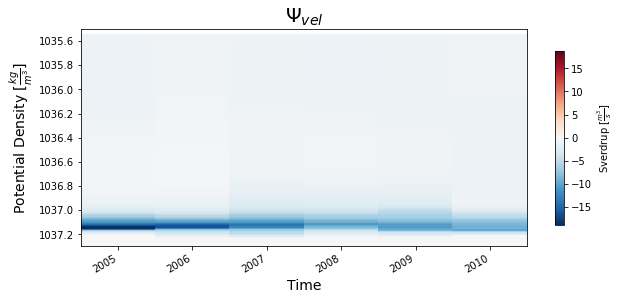

In [31]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1035.5);

(1035.5, 1037.3)

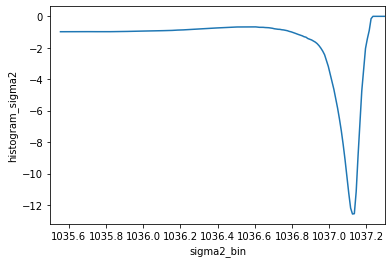

In [39]:
(psi_vel/1e6).mean(dim='time').plot()
plt.xlim(1035.5, 1037.3)

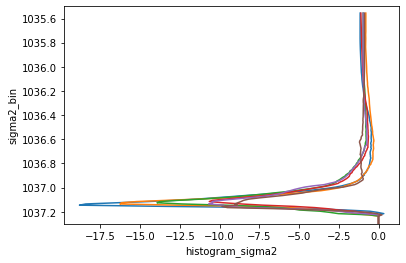

In [40]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin', add_legend=False)
plt.ylim(1037.3, 1035.5);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [52]:
R2 = (psi_adv - psi_vel).load()
R2_th = (psi_adv_th - psi_vel).load()
R2_slt = (psi_adv_slt - psi_vel).load()

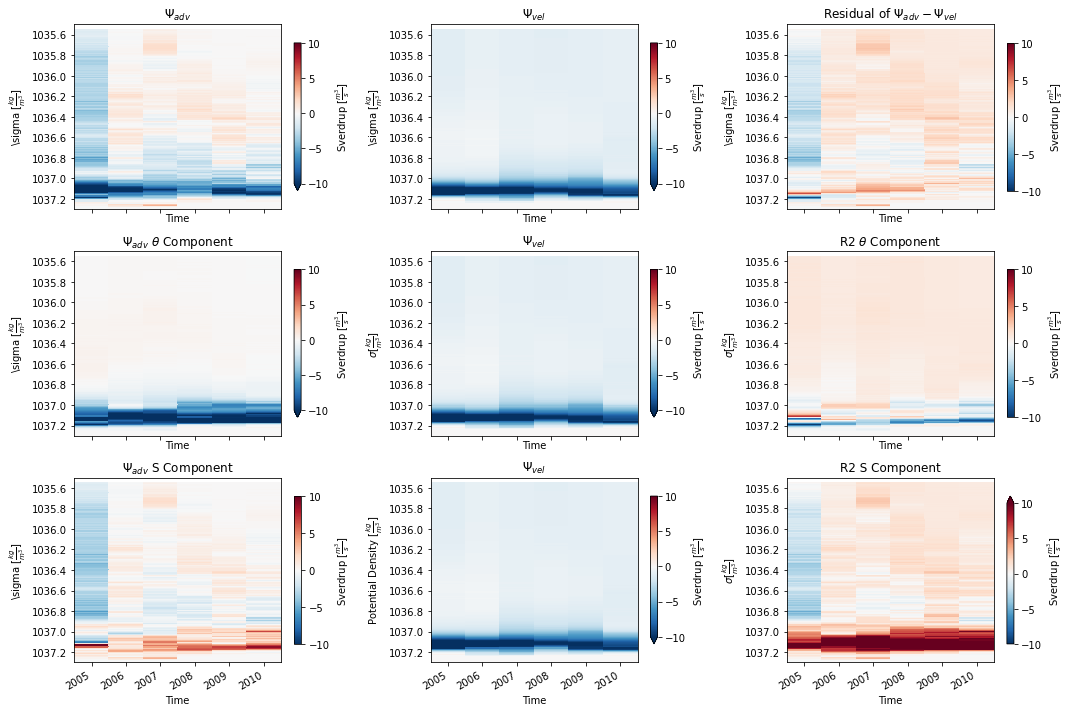

In [53]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,0].set_xlabel('Time')
axes[0,0].set_title(r'$\Psi_{adv}$')
axes[0,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')
axes[0,1].set_title('$\Psi_{vel}$')
axes[0,1].set_ylim(1037.3, 1035.5)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$')
axes[0,2].set_ylim(1037.3, 1035.5)

(psi_adv_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\Psi_{adv}$ $\theta$ Component')
axes[1,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title('$\Psi_{vel}$')
axes[1,1].set_ylim(1037.3, 1035.5)

(R2_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')
axes[1,2].set_title(r'R2 $\theta$ Component')
axes[1,2].set_ylim(1037.3, 1035.5)

(psi_adv_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\Psi_{adv}$ S Component')
axes[2,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title('$\Psi_{vel}$')
axes[2,1].set_ylim(1037.3, 1035.5)

(R2_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R2 S Component')
axes[2,2].set_ylim(1037.3, 1035.5)

plt.tight_layout();

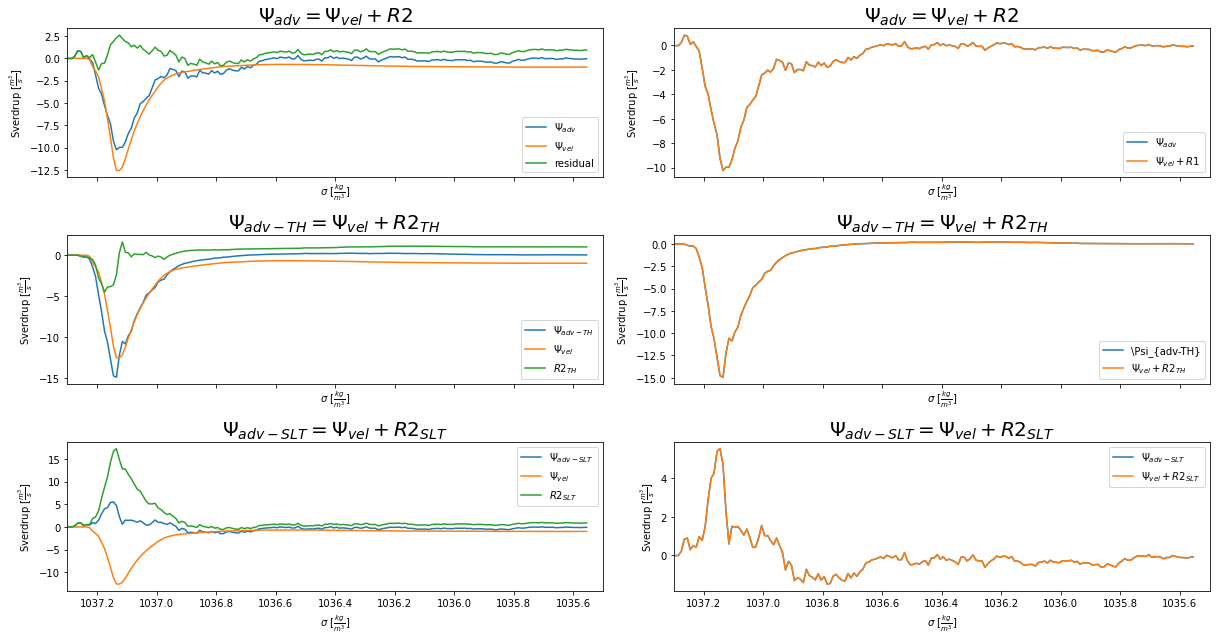

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(17, 9), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
axes[0,0].set_xlim(1037.3, 1035.5)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,1])
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
axes[0,1].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-TH}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{TH}$', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$ ', fontsize=20)
axes[1,0].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label='\Psi_{adv-TH}', ax=axes[1,1])
((psi_vel + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{TH}$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$', fontsize=20)
axes[1,1].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_{SLT}$', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,0].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,1])
((psi_vel + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{SLT}$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,1].set_xlim(1037.3, 1035.5)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>